# Data cleaning and preprocessing


## Libraries


In [ ]:
! pip install pyLDAvis
! pip install --upgrade gensim
! pip install scikit-tda
! pip install gudhi

In [ ]:
# Import libraries

import re                                        # Regular Expressions
import time                                      # Time Function Execution
import datetime          as dt                   # Datetime utilities
import pandas            as pd                   # Dataframe Manipulation
import numpy             as np                   # Matrix Manipulation
import seaborn           as sns                  # Visualization and Plotting
import matplotlib.pyplot as plt                  # Plotting

In [ ]:
from sklearn import preprocessing       # Normalization and Data Transformations
from sklearn import feature_selection   # Feature Selection
from sklearn import feature_extraction  # Feature Extraction
from sklearn import model_selection     # Train-testing Split
from sklearn import utils               # Verification and Safe operations
from collections import Counter         # Frequency of words

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import accuracy_score
from sklearn.cluster  import AgglomerativeClustering
from sklearn.manifold import Isomap
from sklearn.decomposition import TruncatedSVD 

In [ ]:
import nltk                                          # Natural Language Toolkit
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gensim.models import doc2vec 
from nltk.tokenize import word_tokenize
nltk.download('stopwords')                           # Query stopwords list
nltk.download('wordnet')                             # Query wordnet for POS
nltk.download('averaged_perceptron_tagger')          # Used in Lemmatization
nltk.download('punkt')                               # Tokenizer

In [ ]:
from multiprocessing import cpu_count

In [ ]:
# Topological Data Analysis

from   gudhi             import representations               as tda   # Need line to import distance measures.
from   persim.landscapes import PersLandscapeExact                     # Compute persistent landscapes
from   ripser            import Rips                                   # Generate Vietory-Rips complex
import persim                                                          # Generate persistent homology
import plotly.graph_objects        as go                               # Plot simplicial complexes
import kmapper                     as km                               # Mapper algorithm to visualize data
import gudhi                       as gd                               # Topological data analysis



In [ ]:
from pydrive.auth        import GoogleAuth           # Use Google Auth
from pydrive.drive       import GoogleDrive          # Mount Google's drive
from google.colab        import auth                 # Use Google Auth in Colab
from oauth2client.client import GoogleCredentials    # Api to load google credentials

### Libraries Configuration  
Adjust settings from differents libraries

In [ ]:
sns.set_theme()
# Configurations
gd.persistence_graphical_tools._gudhi_matplotlib_use_tex=False         # To disable use of TeX as render

## Load Data  
First load the csv into /content/ directory.  
Run the code above and agree to allow colab to get access to the folder /content/  


In [ ]:
# Import libraries to mount google drive home folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change the string in var filepath to set where the path resides.

In [ ]:
filepath = "/content/drive/MyDrive/EQUIPO NLP/RETO/datos/aspcliamsdb_r_sptkpi.xlsx"

Load Data:
- Set corresponding data type for each column.
- Use first row in csv as column's name.
- Leave rows with no data.

In [ ]:
# Load Dataset
start_time = time.time()  # Measure function time execution
# Set types to each column
dtypes     = {"cm_id":'category', "claim_id":'category',"pl":'category',"productmodel":'string',"partno":'string',"totalamount":'float32',"program_number":'category',"program_name":'string',"descr":'string',"actual_activity":'string',"reseller":'string',"claim_status":'category',"business_type":'category',"activity_subtype":'category',"activity_subtype_id":'category'}
# Load from excel
raw_df     = pd.read_excel(filepath, header=0, verbose=True, dtype=dtypes, thousands=",") 
# Load from CSV
end_time   = time.time()  # End time
print("The time of execution is :",(end_time-start_time) * 10**3, "ms")

Reading sheet 0


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


The time of execution is : 12960.646152496338 ms


### Set column type

In [ ]:
start_time = time.time()                                                            # Measure function time executio
raw_df["sdate"] = pd.to_datetime(raw_df["start_date"], errors="coerce", utc=True)   # Convert to Time Series. Return Date type
raw_df["edate"] = pd.to_datetime(raw_df["end_date"], errors="coerce", utc=True)     # Convert to Time Series. Return Date type
end_time   = time.time()  # End time
print("The time of execution is :",(end_time-start_time) * 10**3, "ms")

The time of execution is : 16.80445671081543 ms


## Data Description

In [ ]:
# Sort Columns by date
raw_df = raw_df.sort_values(by="sdate")
# Delete start_date and end_date columns
raw_df = raw_df.drop(columns=['start_date','end_date'])

## Visualization

## Cleaning

In [ ]:
## Support Functions
def cleantext(text):
    text = str(text)
  # Clean: Convert to lowercase. Remove punctuation and characters, then strip.
    text_ph0 = text.lower()                                      # Lowercase text
    text_ph1 = re.sub('https?://\S+|www\.\S+|\.com', '', text_ph0)     # Remove URLs
    text_ph2 = re.sub('<.*>+', '', text_ph1)                     # Remove content inside brackets
    text_ph3 = re.sub('\n', '', text_ph2)                        # Remove EOL character
    text_ph4 = re.sub(r'[^\w\s]', ' ', str(text_ph3).strip())    # Mod: Add replace with whitespace to handle End.Begin phrase
    text_clean = text_ph4
    return text_clean


def remove_stopwords(stopwords, lst_text):
  return [word for word in lst_text if word not in stopwords]


def gen_stopwords(tokens,gamma):
    # Calculate word frequencies
    word_freq = Counter(tokens)       # Count frequency of words
    threshold = len(word_freq)//gamma # Set a fraction of dataset as filter lim
    stopwords = {word for word, count in word_freq.items() if count >= threshold}
    return stopwords, threshold


def gen_tokenize(dataset):
    # Tokenize and normalize the phrases
    tokens = []
    list_text = dataset              # Dataset to list
    for phrase in list_text:         # Select a phrase
        words = word_tokenize(phrase.lower()) # Lower phrase and tokenize
        tokens.extend(words)
    return tokens    


def stemtext(lst_text):
  ss = nltk.stem.snowball.SnowballStemmer("english", ignore_stopwords=True)     # Improve version of PorterStemming
  return [ss.stem(word) for word in lst_text]


def lemtext(lst_text):
  from nltk.stem   import WordNetLemmatizer
  lem          = WordNetLemmatizer()                           # Instance Lemmatizer
  tagged_words = nltk.pos_tag(lst_text)                        # Tuple with POS
  return [lem.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged_words]


def get_wordnet_pos(treebank_tag):
  from nltk.corpus import wordnet
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN    # If POS is not recognized; Noun assumption.


In [ ]:
# Generate DataFrame with columns name, description and target. Use name and description to predict
df = pd.DataFrame({'Name':raw_df['program_name'],'Descr':raw_df['descr'],'target':raw_df['activity_subtype']})

In [ ]:
df.head(10)

,Name,Descr,target
20494,ASP Meijer BTS '21 Endcap,MARKET DEVELOPMENT FUNDS,BTS
23268,Costco.com C2'22 NB IR Program,undefined,Display
23440,Costco.com C2'22 NB IR Program,undefined,Display
13686,Target OJ5740 Markdown,EOL Program,UNKNOWN
17139,HP Amp Price Elasticity Test,SPECIAL NEGOTIATED DISCOUNT,UNKNOWN
7644,Q118 HPS Toner Private Offer Rebate,SPECIAL NEGOTIATED DISCOUNT,Program
1823,Q118 OPS Ink Private offer Rebate,SPECIAL NEGOTIATED DISCOUNT,Program
13057,DeskJet 3752 BTB'18 Price Protection,SPECIAL NEGOTIATED DISCOUNT,BTB
20606,Envy 4512 BTB'18 Price Protection,SPECIAL NEGOTIATED DISCOUNT,BTB
6096,Q118 OPSToner Private Offer Rebate,SPECIAL NEGOTIATED DISCOUNT,Program


Without stemming

In [ ]:
# Fill undefined values in Descr with Name
replace_undefined                        = df['Name'][df['Descr'] == 'undefined']    # Search in Description the value undefined
df['Descr'].loc[replace_undefined.index] = replace_undefined                         # Replace undefined in Descr with Name of same row
df                                       = df.dropna()                               # Update DF: Remove Nan

# Clean: Convert to lowercase. Remove punctuation and characters, then strip
name_clean  = list(map(cleantext,df['Name']))                                        # Lowercase and remove symbols for every sentence in Name column
descr_clean = list(map(cleantext,df['Descr']))                                       # Lowercase and remove symbols for every sentence in Descr column

# Tokenize phrases
token_name  = [phrase.split() for phrase in name_clean]
token_desc  = [phrase.split() for phrase in descr_clean]

# Load stopwords
nltk_stopwords = set(nltk.corpus.stopwords.words("english"))
# Generate custom stopwords
stopwords, threshold = gen_stopwords(gen_tokenize(name_clean),4)                     # Generate stopwords for Name
stopwords.update(nltk_stopwords)                                                     # Add default stopwordsi
# Generate list to exclude from stopwords
exclude_stopwords = set(map(cleantext,raw_df["activity_subtype_id"].unique()))       # Initialice include subtypes
exclude_stopwords.remove('nan')                                                      # Remove Nan
exclude_stopwords.remove('other')                                                    # Remove Other
exclude_stopwords.remove('unknown')                                                  # Remove Unknown

# Generate a custom exclution list
exclution_list = {'asp','bby','printer','bts','best','buy','printers','amazon','btb','inkjet','ad','costco','walmart','ink','hyperx','toner'}
exclude_stopwords.update(exclution_list)                                             # Union of custom and default exclution set
stopwords_clean = list(stopwords - exclude_stopwords)                                # Remove exclution words from stopwords

# Remove stopwords
name = remove_stopwords(stopwords_clean,token_name)                                  # Stopwords from Name
desc = remove_stopwords(stopwords_clean,token_desc)                                  # Stopwords from Description

# Create clean dataset
df_clean = pd.DataFrame({'Name':name,'Descr':desc,'Target':df['target']})            # Create DF: New DF with clean Data

# Show stopwords
print("Stopwords (Threshold: "+str(threshold)+") :", stopwords_clean)

Stopwords (Threshold: 394) : ['if', '2022', '23', 'nor', 'their', 'both', 'mar', "needn't", "shouldn't", '01', 'ain', 'had', 'am', "don't", 'than', 'its', "that'll", 'so', 'further', 'where', 'theirs', 'now', 'doing', 'but', 'hers', 's', 'before', '2', 'them', 'too', "should've", "you're", 'here', "shan't", 'only', 'were', 'from', 'themselves', 'this', 'mustn', 'weren', 'have', 'your', 'didn', 'again', 'll', 'that', 'during', 'on', 'fy', 'down', 're', 'retail', 'promotion', 'and', 'we', '5', 'at', 'being', 'center', 've', 'has', '03', 'between', 'h', '2021', 'laser', "you'd", 'shan', 'his', "you'll", '12', 'micro', 'o', 'hadn', 'most', 'promos', 'her', "didn't", 'via', 'hps', 'yours', 'how', 'our', 'an', 'very', "you've", 'ops', 'through', 'there', 'can', 'while', 'about', 'dec', 'nov', 'in', 'eol', 'notebook', 'more', 'stay', '1', '30', 'new', '2020', 'wouldn', 'herself', 'or', 't', "aren't", 'a', 'd', '2019', 'be', '22', 'are', 'recycle', 'q2', 'haven', 'ma', 'i', 'when', 'itself', '

In [ ]:
df_clean.head(20)

,Name,Descr,Target
20494,"[asp, meijer, bts, 21, endcap]","[market, development, funds]",BTS
23268,"[costco, c2, 22, nb, ir, program]","[costco, c2, 22, nb, ir, program]",Display
23440,"[costco, c2, 22, nb, ir, program]","[costco, c2, 22, nb, ir, program]",Display
13686,"[target, oj5740, markdown]","[eol, program]",UNKNOWN
17139,"[hp, amp, price, elasticity, test]","[special, negotiated, discount]",UNKNOWN
7644,"[q118, hps, toner, private, offer, rebate]","[special, negotiated, discount]",Program
1823,"[q118, ops, ink, private, offer, rebate]","[special, negotiated, discount]",Program
13057,"[deskjet, 3752, btb, 18, price, protection]","[special, negotiated, discount]",BTB
20606,"[envy, 4512, btb, 18, price, protection]","[special, negotiated, discount]",BTB
6096,"[q118, opstoner, private, offer, rebate]","[special, negotiated, discount]",Program


with stemming

In [ ]:
# Apply stemming
name_stem   = [lemtext(sentence) for sentence in token_name]
desc_stem   = [lemtext(sentence) for sentence in token_desc]

# Load stopwords
nltk_stopwords = set(nltk.corpus.stopwords.words("english"))
# Generate custom stopwords
stopwords, threshold = gen_stopwords(gen_tokenize(name_clean),4)                      # Generate stopwords for Name
stopwords.update(nltk_stopwords)                                                     # Add default stopwordsi
# Generate list to exclude from stopwords
exclude_stopwords = set(map(cleantext,raw_df["activity_subtype_id"].unique()))       # Initialice include subtypes
exclude_stopwords.remove('nan')                                                      # Remove Nan
exclude_stopwords.remove('other')                                                    # Remove Other
exclude_stopwords.remove('unknown')                                                  # Remove Unknown

# Generate a custom exclution list
exclution_list = {'asp','bby','printer','bts','best','buy','printers','amazon','btb','inkjet','ad','costco','walmart','ink','hyperx','toner'}
exclude_stopwords.update(exclution_list)                                             # Union of custom and default exclution set
stopwords_clean = list(stopwords - exclude_stopwords)                                # Remove exclution words from stopwords

# Remove stopwords
name = remove_stopwords(stopwords_clean,name_stem)                                   # Stopwords from Name
desc = remove_stopwords(stopwords_clean,desc_stem)                                   # Stopwords from Description

# Create clean dataset
df_stem = pd.DataFrame({'Name':name,'Descr':desc,'Target':df['target']})             # Create DF: New DF with clean Data

# Show stopwords
print("Stopwords (Threshold: "+str(threshold)+") :", stopwords_clean)

Stopwords (Threshold: 394) : ['if', '2022', '23', 'nor', 'their', 'both', 'mar', "needn't", "shouldn't", '01', 'ain', 'had', 'am', "don't", 'than', 'its', "that'll", 'so', 'further', 'where', 'theirs', 'now', 'doing', 'but', 'hers', 's', 'before', '2', 'them', 'too', "should've", "you're", 'here', "shan't", 'only', 'were', 'from', 'themselves', 'this', 'mustn', 'weren', 'have', 'your', 'didn', 'again', 'll', 'that', 'during', 'on', 'fy', 'down', 're', 'retail', 'promotion', 'and', 'we', '5', 'at', 'being', 'center', 've', 'has', '03', 'between', 'h', '2021', 'laser', "you'd", 'shan', 'his', "you'll", '12', 'micro', 'o', 'hadn', 'most', 'promos', 'her', "didn't", 'via', 'hps', 'yours', 'how', 'our', 'an', 'very', "you've", 'ops', 'through', 'there', 'can', 'while', 'about', 'dec', 'nov', 'in', 'eol', 'notebook', 'more', 'stay', '1', '30', 'new', '2020', 'wouldn', 'herself', 'or', 't', "aren't", 'a', 'd', '2019', 'be', '22', 'are', 'recycle', 'q2', 'haven', 'ma', 'i', 'when', 'itself', '

In [ ]:
df_stem.head(15)

,Name,Descr,Target
20494,"[asp, meijer, bts, 21, endcap]","[market, development, fund]",BTS
23268,"[costco, c2, 22, nb, ir, program]","[costco, c2, 22, nb, ir, program]",Display
23440,"[costco, c2, 22, nb, ir, program]","[costco, c2, 22, nb, ir, program]",Display
13686,"[target, oj5740, markdown]","[eol, program]",UNKNOWN
17139,"[hp, amp, price, elasticity, test]","[special, negotiate, discount]",UNKNOWN
7644,"[q118, hp, toner, private, offer, rebate]","[special, negotiate, discount]",Program
1823,"[q118, ops, ink, private, offer, rebate]","[special, negotiate, discount]",Program
13057,"[deskjet, 3752, btb, 18, price, protection]","[special, negotiate, discount]",BTB
20606,"[envy, 4512, btb, 18, price, protection]","[special, negotiate, discount]",BTB
6096,"[q118, opstoner, private, offer, rebate]","[special, negotiate, discount]",Program


# Start from here

In [ ]:
data_stem    = pd.read_csv('/content/drive/MyDrive/EQUIPO NLP/RETO/datos/df_lem.csv')

In [ ]:
data = data_stem.set_index('index')

In [ ]:
# Split dataset into trainning-testing and validation
train_test_df  = data[['Target','Name','Descr']].query("Target == 'BTB'")
validation_df  = data[['Target','Name','Descr']].query("Target == 'BTS'")

In [ ]:
train_test_df.head(10)

,Target,Name,Descr
index,,,
13057,BTB,"['deskjet', '3752', 'btb', '18', 'price', 'pro...","['special', 'negotiate', 'discount']"
20606,BTB,"['envy', '4512', 'btb', '18', 'price', 'protec...","['special', 'negotiate', 'discount']"
2797,BTB,"['asp', 'staple', 'btb', 'ojp', '9015', 'endcap']","['market', 'development', 'fund']"
11674,BTB,"['asp', 'staple', 'btb', 'lj', 'm15w', '29w', ...","['market', 'development', 'fund']"
2027,BTB,"['asp', 'staple', 'btb', 'ojp', '9015', 'endcap']","['market', 'development', 'fund']"
6162,BTB,"['bsd', 'back', 'business']","['market', 'development', 'fund']"
3846,BTB,"['bsd', 'back', 'business']","['market', 'development', 'fund']"
8514,BTB,"['bsd', 'back', 'business']","['market', 'development', 'fund']"
17368,BTB,"['asp', 'bj', 'bbm', '19', 'btb']","['special', 'negotiate', 'discount']"


In [ ]:
# Create a bag of words
from gensim import corpora
text_data  = train_test_df["Name"]

In [ ]:
dictionary = corpora.Dictionary(text_data)
corpus     = [dictionary.doc2bow(text) for text in text_data]

In [ ]:
data["Name"]

index
20494                   ['asp', 'meijer', 'bts', 'endcap']
23268                                           ['costco']
23440                                           ['costco']
13686                     ['target', 'oj5740', 'markdown']
17139               ['amp', 'price', 'elasticity', 'test']
                               ...                        
22815           ['electronic', 'express', 'nae', 'hyperx']
23032                                          ['b2b2023']
23038                                          ['b2b2023']
23041                                          ['b2b2023']
23042    ['asp', 'lj', 'm29w', 'store', 'offer', 'hol',...
Name: Name, Length: 21091, dtype: object

In [ ]:
import pickle
pickle.dump(corpus,open('/content/drive/MyDrive/EQUIPO NLP/RETO/datos/corpus.pkl','wb'))
dictionary.save('/content/drive/MyDrive/EQUIPO NLP/RETO/datos/dictionary_stem.gensim')

In [ ]:
NUM_topics = 11
ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=NUM_topics,id2word=dictionary,passes=20)
ldamodel.save('/content/drive/MyDrive/EQUIPO NLP/RETO/datos/model11.gensim')

In [ ]:
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.261*"23" + 0.084*"back" + 0.052*"inkjet" + 0.047*"search" + 0.046*"printer" + 0.039*"pay" + 0.038*"on" + 0.037*"aug" + 0.036*"product" + 0.034*"always"')
(1, '0.305*"np" + 0.124*"promotion" + 0.048*"offer" + 0.046*"b2b2023" + 0.046*"instant" + 0.043*"rebate" + 0.043*"new" + 0.042*"age" + 0.037*"stay" + 0.037*"healthy"')
(2, '0.151*"cycle" + 0.084*"asp" + 0.072*"c1" + 0.064*"bts" + 0.062*"via" + 0.035*"funding" + 0.032*"nae" + 0.022*"b" + 0.021*"printer" + 0.019*"egg"')
(3, '0.141*"micro" + 0.131*"center" + 0.121*"jan" + 0.089*"recycle" + 0.070*"53955" + 0.060*"in" + 0.058*"and" + 0.046*"mar" + 0.046*"trade" + 0.041*"2020"')
(4, '0.191*"22" + 0.118*"12" + 0.089*"2022" + 0.070*"bby" + 0.066*"10" + 0.047*"31" + 0.044*"promo" + 0.028*"04" + 0.027*"6" + 0.025*"09"')
(5, '0.223*"program" + 0.136*"22" + 0.136*"ir" + 0.112*"costco" + 0.082*"nb" + 0.075*"c2" + 0.035*"warehouse" + 0.025*"october" + 0.025*"tank" + 0.024*"dt"')
(6, '0.289*"2023" + 0.065*"feb" + 0.061*"business" + 0.060*"pc"

In [ ]:
#dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
#corpus = pickle.load(open('corpus.pkl', 'rb'))
#lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

In [ ]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel,corpus,dictionary,sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Classification


In [ ]:
# Split dataset into trainning-testing and validation
train_test_df  = data[['Target','Name','Descr']].query("Target == 'BTB'")
validation_df  = data[['Target','Name','Descr']].query("Target == 'BTS'")

In [ ]:
# mapping and dropping nan values

# Create a bijection from program category to ordinals
orden = {
"Program":        int(0),
"Display":        int(1),
"BTB":            int(2),
"Search":         int(3),
"Holiday":        int(4),
"BTS":            int(5),
"Email":          int(6),
"Digital":        int(7),
"Trad_media":     int(8)
}

train_test_df['Target'] = train_test_df['Target'].map(orden)    # Apply the bijection

In [ ]:
# Train and test split
X_train, X_test, y_train, y_test = model_selection.train_test_split (train_test_df['Name'], train_test_df[['Target']] , test_size=0.2)
X_train_c, X_test_c, y_train_c, y_test_c = model_selection.train_test_split (validation_df['Name'], validation_df[['Target']] , test_size=0.2)

# Representation

In [ ]:
#model_params

#word2vec
vector_size = 50
window = 3
min_count = 0
use_sg = 0

#random forest
max_depth = 4

In [ ]:
#word2vec model
w2v_model = Word2Vec(X_train,
                     vector_size=vector_size,
                     window=window,
                     min_count=min_count,
                     sg=use_sg,
                     workers=cpu_count())

In [ ]:
#word2vec model
w2v_model_c = Word2Vec(X_train_c,
                     vector_size=vector_size,
                     window=window,
                     min_count=min_count,
                     sg=use_sg,
                     workers=cpu_count())

# Data classification


In [ ]:
# Apply word embedding to training and testing
words = w2v_model.wv.index_to_key
X_train_vec = []
for phrase in X_train:
    vec = np.zeros(vector_size).reshape(1,vector_size)
    for word in phrase:
        if word in words:
            vec += np.array(w2v_model.wv[word].reshape(1,vector_size))
    X_train_vec.append(vec)
X_train_vec = np.array(X_train_vec).reshape(len(X_train_vec),vector_size)

X_test_vec = []
for phrase in X_test:
    vec = np.zeros(vector_size).reshape(1,vector_size)
    for word in phrase:
        if word in words:
            vec += np.array(w2v_model.wv[word].reshape(1,vector_size))
    X_test_vec.append(vec)i
X_test_vec = np.array(X_test_vec).reshape(len(X_test_vec),vector_size)

In [ ]:
# Apply word embedding to training and testing
words = w2v_model_c.wv.index_to_key
X_train_vec_c = []
for phrase in X_train_c:
    vec = np.zeros(vector_size).reshape(1,vector_size)
    for word in phrase:
        if word in words:
            vec += np.array(w2v_model_c.wv[word].reshape(1,vector_size))
    X_train_vec_c.append(vec)
X_train_vec_c = np.array(X_train_vec_c).reshape(len(X_train_vec_c),vector_size)

X_test_vec_c = []
for phrase in X_test_c:
    vec = np.zeros(vector_size).reshape(1,vector_size)
    for word in phrase:
        if word in words:
            vec += np.array(w2v_model_c.wv[word].reshape(1,vector_size))
    X_test_vec_c.append(vec)
X_test_vec_c = np.array(X_test_vec_c).reshape(len(X_test_vec_c),vector_size)

In [ ]:
X_train_vec[0]

array([ -7.3517554 ,  19.32404017,  11.84839672,   5.62393356,
        12.57782929,  -0.18740291,   0.40199654,  -1.53054462,
       -12.15656466,   0.30941979,  -3.87794272,  -3.26136064,
        -4.52073587, -15.1330124 ,  21.1975346 , -10.60999744,
         1.20894676,  -4.81524178,   3.56250743,  -8.32344874,
        -9.05911031,  -8.28643242,   6.22673   , -23.84215567,
        -0.68572439,  -2.14330946,  -5.29773415,  -4.13506517,
        18.5194843 ,  10.35037226,  15.27299764,   2.06764724,
        -3.62215553,   3.88083118,  -9.69470058,   9.41066504,
        -8.8866239 ,  16.01398491,   8.32366031,   8.37682516,
        13.45765529,  -5.69987614,  -0.28865298,   6.22078337,
        -2.36425393,   0.71231673,  -8.32422829,  -8.73650192,
        -8.76174213,  -6.63127819])

In [ ]:
# random forest classification
clf = RandomForestClassifier(max_depth=max_depth, random_state=11)
clf.fit(X_train_vec, np.ravel(y_train))
y_pred = clf.predict(X_test_vec)
accuracy_score(y_test, y_pred)

0.6776371308016877

## Doc2vec test

In [ ]:
# To train the model we need a list of tagged documents
def tagged_document(list_of_ListOfWords,tags):
  for x, ListOfWords in enumerate(list_of_ListOfWords):
    yield doc2vec.TaggedDocument(ListOfWords, tags[x])

tags = np.array(y_train)
# training data
data_train = list(tagged_document(X_train,tags))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Initialize the model
d2v_model = doc2vec.Doc2Vec(vector_size = 40, min_count = 2, epochs = 30)
 
# build the vocabulary
d2v_model.build_vocab(data_train)
 
# Train Doc2Vec model
d2v_model.train(data_train, total_examples = d2v_model.corpus_count, epochs = d2v_model.epochs)

In [ ]:
# Apply word embedding to training and testing
X_train_doc = []
for phrase in X_train:
    vec = d2v_model.infer_vector(phrase)
    X_train_doc.append(vec)
X_train_doc = np.array(X_train_vec).reshape(len(X_train_vec),vector_size)

X_test_doc = []
for phrase in X_test:
    vec = d2v_model.infer_vector(phrase)
    X_test_doc.append(vec)
X_test_doc = np.array(X_test_vec).reshape(len(X_test_vec),vector_size)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# random forest classification
clf = RandomForestClassifier(max_depth=max_depth, random_state=11)
clf.fit(X_train_doc, np.ravel(y_train))
y_pred = clf.predict(X_test_doc)
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.7464135021097047

## Topological Data Analysis

In [ ]:
import gudhi
# Test compare topology from X , Y

rips_complex_bts = gudhi.RipsComplex(points=X_train_vec)
rips_complex_btb = gudhi.RipsComplex(points=X_train_vec_c)

In [ ]:
simplex_tree = rips_complex_bts.create_simplex_tree()
simplex_tree_c = rips_complex_btb.create_simplex_tree()

In [ ]:
simplex_tree.compute_persistence()
simplex_tree_c.compute_persistence()

In [ ]:
persis = simplex_tree.persistence()
persis_c = simplex_tree_c.persistence()

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

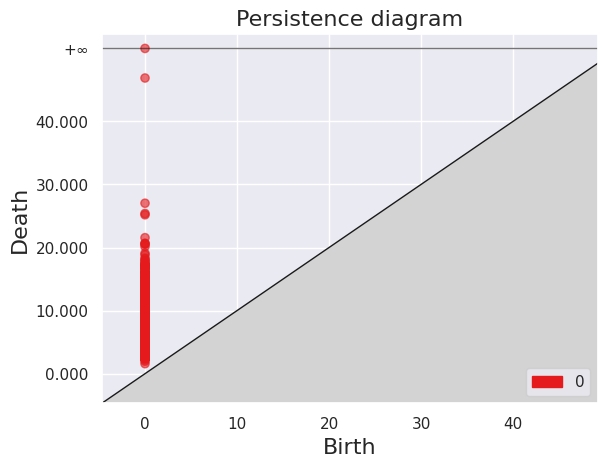

In [ ]:
gudhi.plot_persistence_diagram(persis)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

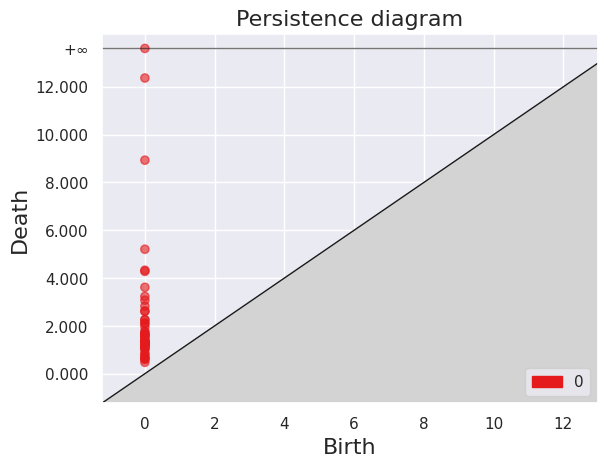

In [ ]:
gudhi.plot_persistence_diagram(persis_c)

In [ ]:
landscape = gudhi.

In [ ]:
mapper = km.KeplerMapper(verbose=2)
projected_X = mapper.fit_transform(X_train_vec,
                                   projection=[TruncatedSVD(n_components=vector_size//3,random_state=11),
                                               Isomap(n_components=2,
                                                      n_jobs=-1)])

In [ ]:
graph = mapper.map(projected_X,
                   X=None,
                   clusterer=AgglomerativeClustering(n_clusters=9,
                                                             linkage="complete",
                                                             affinity="cosine"),
                   cover=Cover(perc_overlap=0.33))

In [ ]:
_ = mapper.visualize(graph,
                        path_html="/content/newsgroups20.html",
                        lens=projected_X,
                        lens_names=["ISOMAP1", "ISOMAP2"],
                        title="Word2Vec embedding TDA Train",
                        color_values=y_train,
                        color_function_name='target')

#jupyter.display("/content/newsgroups20.html")

In [ ]:
words_dict = w2v_model.wv.key_to_index

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
